# Домашнее задание. Классификация изображений

Сегодня вам предстоить помочь телекомпании FOX в обработке их контента. Как вы знаете, сериал "Симпсоны" идет на телеэкранах более 25 лет, и за это время скопилось очень много видеоматериала. Персоонажи менялись вместе с изменяющимися графическими технологиями, и Гомер Симпсон-2018 не очень похож на Гомера Симпсона-1989. В этом задании вам необходимо классифицировать персонажей, проживающих в Спрингфилде. Думаю, нет смысла представлять каждого из них в отдельности.



### Установка зависимостей

In [5]:
import torch
import numpy as np
import PIL

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [6]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [7]:
!unzip -q /content/gdrive/MyDrive/journey-springfield.zip -d data

In [8]:
!ls data

characters_illustration.png  sample_submission.csv  testset  train


In [9]:
!nvidia-smi
torch.cuda.is_available()

Mon Apr 17 08:23:31 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8     9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

True

В нашем тесте будет 990 картнок, для которых вам будет необходимо предсказать класс.

In [63]:
import pickle
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path
from collections import Counter

from torchvision import datasets, transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import WeightedRandomSampler
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки 
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


In [11]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

https://jhui.github.io/2018/02/09/PyTorch-Data-loading-preprocess_torchvision/


Ниже мы исспользуем враппер над датасетом для удобной работы. Вам стоит понимать, что происходит с LabelEncoder и  с torch.Transformation. 

ToTensor конвертирует  PIL Image с параметрами в диапазоне [0, 255] (как все пиксели) в FloatTensor размера (C x H x W) [0,1] , затем производится масштабирование:
$input = \frac{input - \mu}{\text{standard deviation}} $, <br>       константы - средние и дисперсии по каналам на основе ImageNet


Стоит также отметить, что мы переопределяем метод __getitem__ для удобства работы с данной структурой данных.
 Также используется LabelEncoder для преобразования строковых меток классов в id и обратно. В описании датасета указано, что картинки разного размера, так как брались напрямую с видео, поэтому следуем привести их к одному размер (это делает метод  _prepare_sample) 

In [12]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [13]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [14]:
TRAIN_DIR = Path('data/train/simpsons_dataset')
TEST_DIR = Path('data/testset/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [15]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.2, \
                                          stratify=train_val_labels)

In [16]:
val_dataset = SimpsonsDataset(val_files, mode='val')

In [ ]:
# uncomment if you have problem with pillow
# def register_extension(id, extension): Image.EXTENSION[extension.lower()] = id.upper()
# Image.register_extension = register_extension
# def register_extensions(id, extensions): 
#     for extension in extensions: register_extension(id, extension)
# Image.register_extensions = register_extensions

Давайте посмотрим на наших героев внутри датасета.

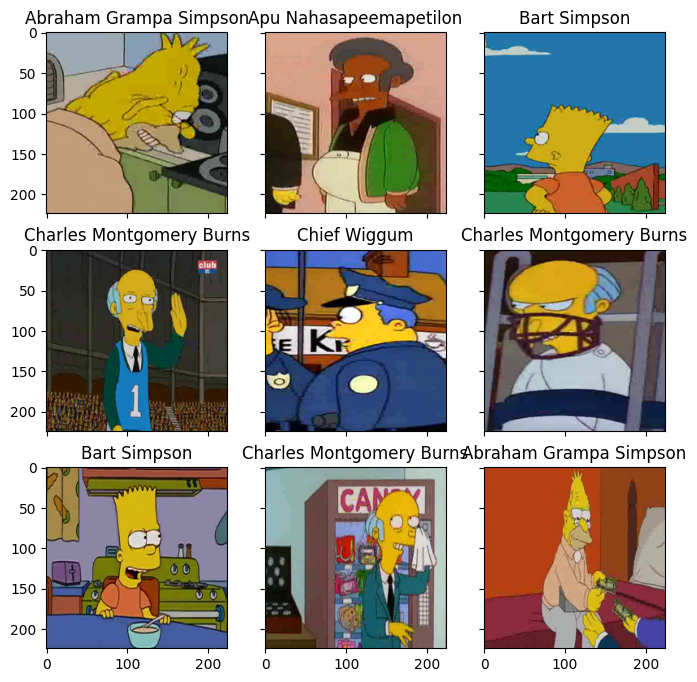

In [17]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

In [60]:
info = pd.Series(train_val_labels).value_counts().sort_values().to_frame("count")
info

,count
lionel_hutz,3
troy_mcclure,8
disco_stu,8
miss_hoover,17
gil,27
fat_tony,27
otto_mann,32
sideshow_mel,40
agnes_skinner,42
rainier_wolfcastle,45


Классы очень сильно несбалансированны. Поэтому произведём аугментацию данных

In [62]:
augmentations = transforms.RandomChoice([
    transforms.Compose([
        transforms.Resize(size=300, max_size=301),
        transforms.CenterCrop(size=300),
        transforms.RandomCrop(250)
    ]),
    transforms.RandomRotation(degrees=(-25, 25)),
    transforms.RandomHorizontalFlip(p=1),
])
train_transforms = transforms.Compose([
    augmentations,
    transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)),
    transforms.Lambda(lambda x: np.array(x, dtype="float32") / 255),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) ,
])
train_dataset = datasets.ImageFolder(root=TRAIN_DIR, transform=train_transforms)

In [64]:
class_count = Counter(train_dataset.targets)
class_weights = {i: 1/c for i, c in class_count.items()}
sample_weights = [0] * len(train_dataset)
for i, (data, label) in enumerate(tqdm(train_dataset)):
    class_weight = class_weights[label]
    sample_weights[i] = class_weight

N = max(class_count.values()) * len(class_count)
train_sampler = WeightedRandomSampler(sample_weights, num_samples=N, replacement=True)
train_loader = DataLoader(train_dataset, batch_size=128, sampler=train_sampler, num_workers=2)

100%|██████████| 20933/20933 [02:06<00:00, 165.61it/s]


In [65]:
count = Counter()
for data, labels in tqdm(train_loader):
    count += Counter(labels.tolist())
print(sum(count.values()), count)

100%|██████████| 737/737 [08:41<00:00,  1.41it/s]

94332 Counter({16: 2315, 20: 2314, 18: 2312, 28: 2310, 41: 2302, 36: 2290, 24: 2285, 22: 2285, 35: 2283, 31: 2276, 40: 2275, 6: 2275, 5: 2272, 8: 2269, 19: 2268, 9: 2266, 29: 2260, 2: 2259, 33: 2259, 11: 2257, 0: 2255, 38: 2252, 10: 2250, 7: 2248, 21: 2244, 26: 2243, 15: 2241, 39: 2232, 34: 2231, 3: 2229, 23: 2213, 1: 2208, 30: 2201, 27: 2201, 12: 2196, 14: 2195, 32: 2191, 25: 2185, 37: 2185, 17: 2170, 13: 2167, 4: 2163})


Теперь видим, что классы стали сбалансированны

### Построение нейросети

Попробуем реализовать Transfer Learning с использованием предобученной сети EfficientNet-b0


In [70]:
import torchvision.models as models

model = models.efficientnet_b0(pretrained=True)

for param in model.features[:-5].parameters():
    param.requires_grad = False

num_feature = model.classifier[1].in_features
n_classes = len(np.unique(train_val_labels))
model.classifier[1] = nn.Linear(num_feature, n_classes)

Отправим нашу модель на CUDA и создадим scheduler

In [71]:
if torch.cuda.is_available():
    model.cuda()

opt = torch.optim.Adam(model.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=7, gamma=0.1)

In [72]:
def fit_epoch(model, train_loader, criterion, optimizer, sheduler):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        sheduler.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [73]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [74]:
def train(train_files, val_files, sheduler, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters(), lr=3e-4)
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt, sheduler)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

In [75]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

Запустим дообучение сети

In [76]:
history = train(train_dataset, val_dataset, scheduler, model=model, epochs=15, batch_size=128)

epoch:   0%|          | 0/15 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


loss 0.9387833519923683


epoch:   7%|▋         | 1/15 [03:45<52:34, 225.29s/it]


Epoch 001 train_loss: 0.9388     val_loss 0.1863 train_acc 0.7949 val_acc 0.9546
loss 0.18733777122536738


epoch:  13%|█▎        | 2/15 [07:22<47:48, 220.66s/it]


Epoch 002 train_loss: 0.1873     val_loss 0.1670 train_acc 0.9522 val_acc 0.9529
loss 0.09920781008446831


epoch:  20%|██        | 3/15 [10:59<43:48, 219.03s/it]


Epoch 003 train_loss: 0.0992     val_loss 0.0544 train_acc 0.9751 val_acc 0.9847
loss 0.0707243543353327


epoch:  27%|██▋       | 4/15 [14:37<40:01, 218.35s/it]


Epoch 004 train_loss: 0.0707     val_loss 0.0362 train_acc 0.9801 val_acc 0.9919
loss 0.0440272972402733


epoch:  33%|███▎      | 5/15 [18:13<36:16, 217.67s/it]


Epoch 005 train_loss: 0.0440     val_loss 0.0311 train_acc 0.9890 val_acc 0.9904
loss 0.04561148410922745


epoch:  40%|████      | 6/15 [21:50<32:37, 217.54s/it]


Epoch 006 train_loss: 0.0456     val_loss 0.0250 train_acc 0.9875 val_acc 0.9933
loss 0.030686291139249856


epoch:  47%|████▋     | 7/15 [25:28<28:59, 217.45s/it]


Epoch 007 train_loss: 0.0307     val_loss 0.0276 train_acc 0.9917 val_acc 0.9912
loss 0.031559441551889215


epoch:  53%|█████▎    | 8/15 [29:05<25:22, 217.55s/it]


Epoch 008 train_loss: 0.0316     val_loss 0.0184 train_acc 0.9910 val_acc 0.9943
loss 0.025708916558361453


epoch:  60%|██████    | 9/15 [32:41<21:40, 216.82s/it]


Epoch 009 train_loss: 0.0257     val_loss 0.0147 train_acc 0.9927 val_acc 0.9957
loss 0.028700381976286743


epoch:  67%|██████▋   | 10/15 [36:21<18:09, 217.87s/it]


Epoch 010 train_loss: 0.0287     val_loss 0.0171 train_acc 0.9915 val_acc 0.9943
loss 0.020720865477700197


epoch:  73%|███████▎  | 11/15 [39:59<14:32, 218.03s/it]


Epoch 011 train_loss: 0.0207     val_loss 0.0173 train_acc 0.9938 val_acc 0.9955
loss 0.02149336908477289


epoch:  80%|████████  | 12/15 [43:37<10:53, 217.94s/it]


Epoch 012 train_loss: 0.0215     val_loss 0.0128 train_acc 0.9935 val_acc 0.9955
loss 0.02093824220409545


epoch:  87%|████████▋ | 13/15 [47:15<07:15, 217.91s/it]


Epoch 013 train_loss: 0.0209     val_loss 0.0227 train_acc 0.9942 val_acc 0.9931
loss 0.021817822091187804


epoch:  93%|█████████▎| 14/15 [50:56<03:38, 218.76s/it]


Epoch 014 train_loss: 0.0218     val_loss 0.0128 train_acc 0.9937 val_acc 0.9955
loss 0.023304446085042473


epoch: 100%|██████████| 15/15 [54:44<00:00, 218.95s/it]


Epoch 015 train_loss: 0.0233     val_loss 0.0225 train_acc 0.9933 val_acc 0.9924


Построим кривые обучения

In [77]:
loss, acc, val_loss, val_acc = zip(*history)

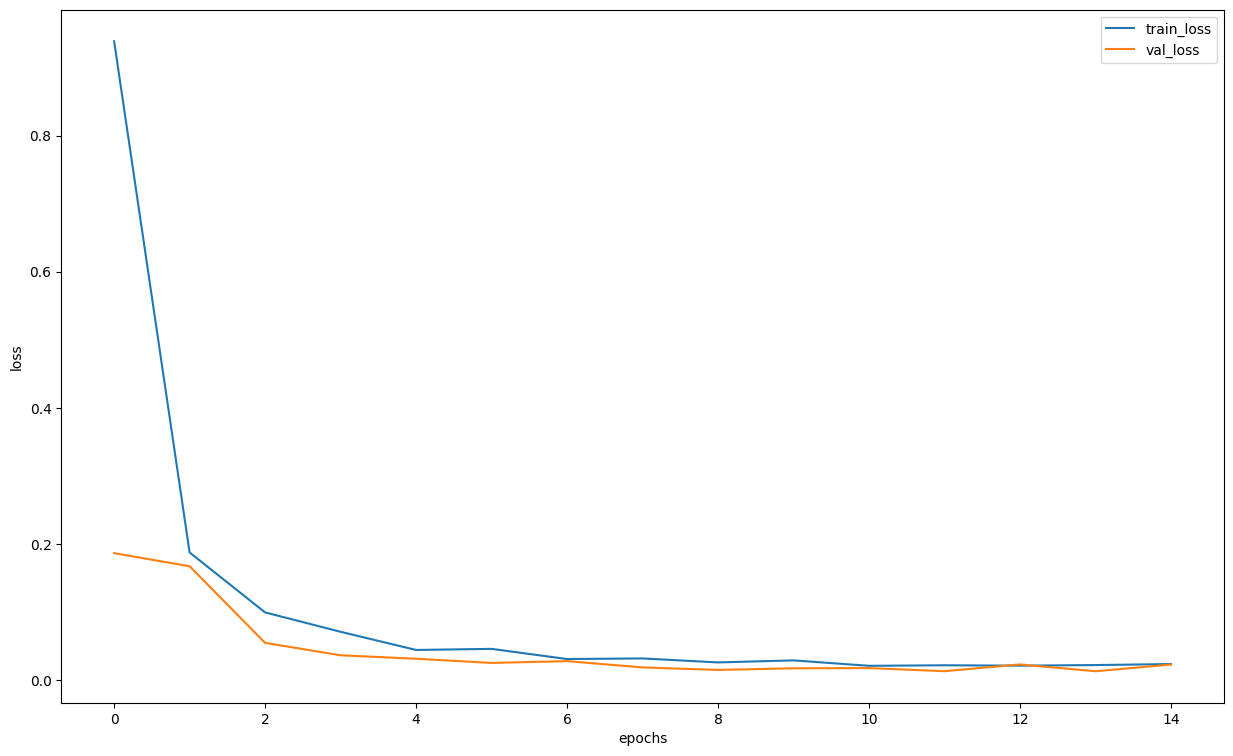

In [78]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

### Ну и что теперь со всем этим делать?

![alt text](https://www.indiewire.com/wp-content/uploads/2014/08/the-simpsons.jpg)

Хорошо бы понять, как сделать сабмит. 
У нас есть сеть и методы eval у нее, которые позволяют перевести сеть в режим предсказания. Стоит понимать, что у нашей модели на последнем слое стоит softmax, которые позволяет получить вектор вероятностей  того, что объект относится к тому или иному классу. Давайте воспользуемся этим.

In [79]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [80]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(model, ex_img.unsqueeze(0))

In [81]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(model, imgs)

In [82]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [83]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

preds_class = label_encoder.transform(preds_class)

Обратите внимание, что метрика, которую необходимо оптимизировать в конкурсе --- f1-score. Вычислим целевую метрику на валидационной выборке.

In [84]:
from sklearn.metrics import f1_score

f1_score(actual_labels, y_pred, average='micro')


1.0

Сделаем классную визуализацию,  чтобы посмотреть насколько сеть уверена в своих ответах. Можете исспользовать это, чтобы отлаживать правильность вывода.

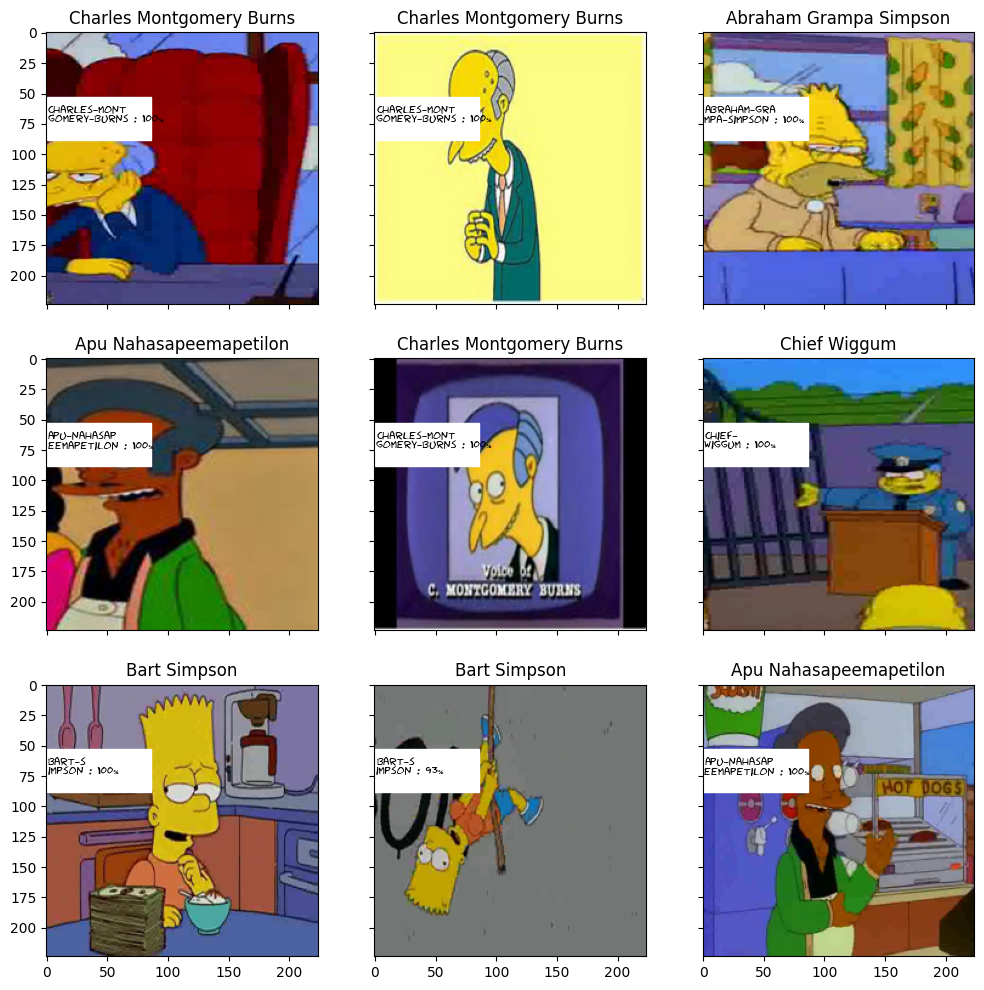

In [86]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(model, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

### Submit на Kaggle

![alt text](https://i.redd.it/nuaphfioz0211.jpg)

In [87]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(model, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]


In [88]:
! ls 

data  gdrive  label_encoder.pkl  sample_data


In [89]:
import pandas as pd
my_submit = pd.read_csv("data/sample_submission.csv")
# my_submit = pd.DataFrame({'Image_id': test_filenames, 'Expected': preds})
my_submit.head()

,Id,Expected
0,img0.jpg,bart_simpson
1,img1.jpg,bart_simpson
2,img2.jpg,bart_simpson
3,img3.jpg,bart_simpson
4,img4.jpg,bart_simpson


In [90]:
pd.DataFrame({"Id": test_filenames, "Expected": preds}).to_csv('data/simple_cnn_baseline.csv', index=False)